# Klasyfikacja Pingwinów

Zadanie: Wykorzystaj zbiór penguins.csv (pobierz), w którym są cechy dla różnych gatunków pingwinów, wykonaj eksploracje, a następnie naucz poznane modele.

### 1. Zaimportowanie potrzebnych bibliotek

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.plotting import plot_decision_regions





### 2. Wczytanie i eksploracja danych

In [3]:
df = pd.read_csv('penguins.csv')
df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [5]:
df.isnull().sum()

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

In [6]:
df[df.isnull().any(axis=1)]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


Brakuje wartości tylko w 2 wierszach. Usunięcie tych wierszy nie ma większego wpływu na jakość danych. Usuwam więc wiersze z brakującymi danymi.

In [7]:
df.dropna(inplace=True)

In [8]:
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'
X, y = df[features], df[target]
print('X:')
display(X)
print('\ny:')
display(y)

X:


,CulmenLength,CulmenDepth,FlipperLength,BodyMass
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0



y:


0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: Species, Length: 342, dtype: int64

In [9]:
pd.Series(y).value_counts(normalize=True)

Species
0    0.441520
1    0.359649
2    0.198830
Name: proportion, dtype: float64

In [10]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


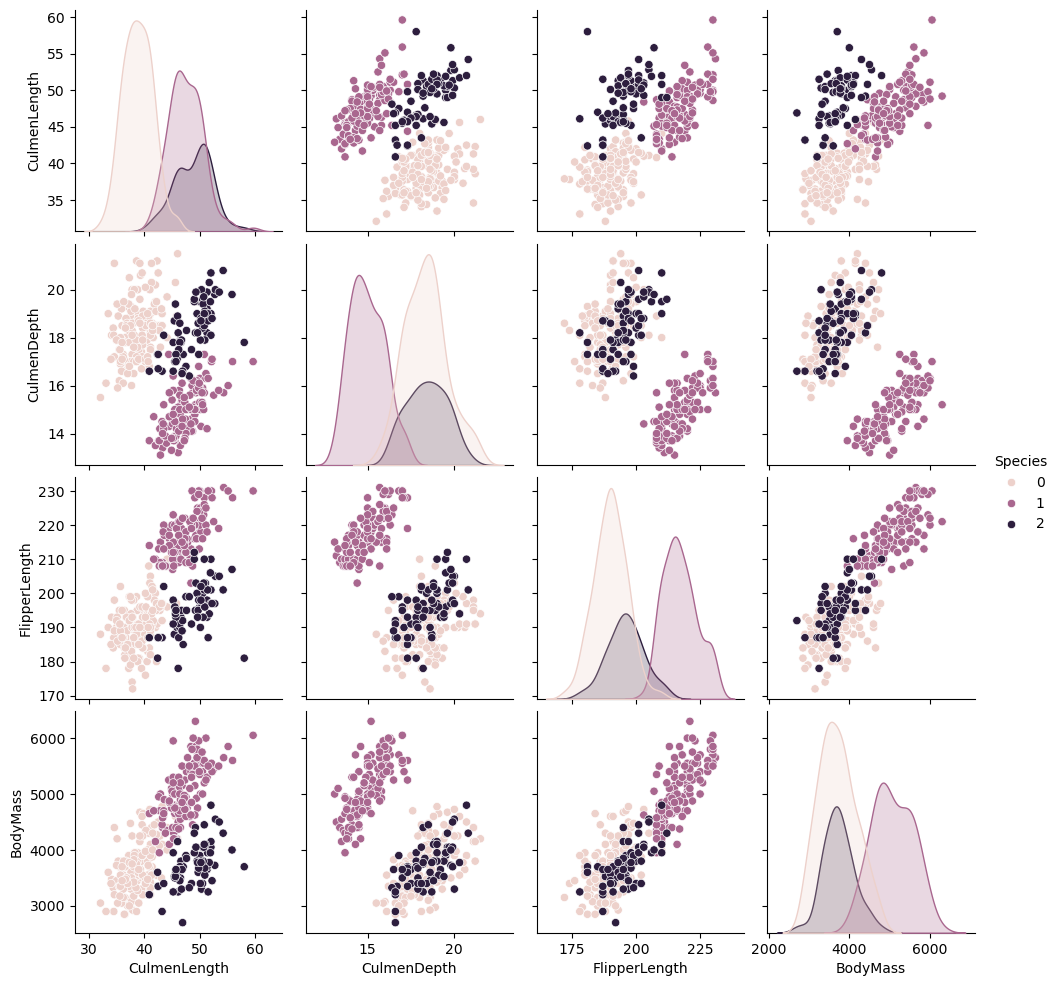

In [58]:
sns.pairplot(df, hue='Species')

Unikalne wartości: 164


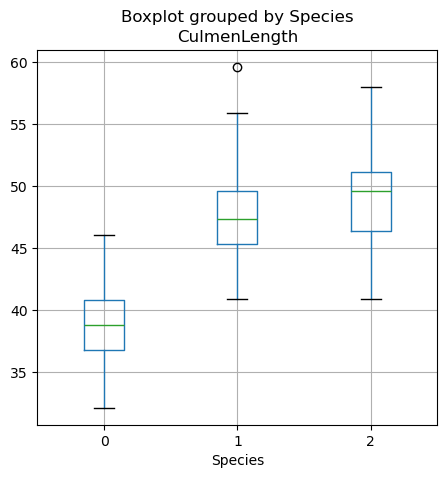

Unikalne wartości: 80


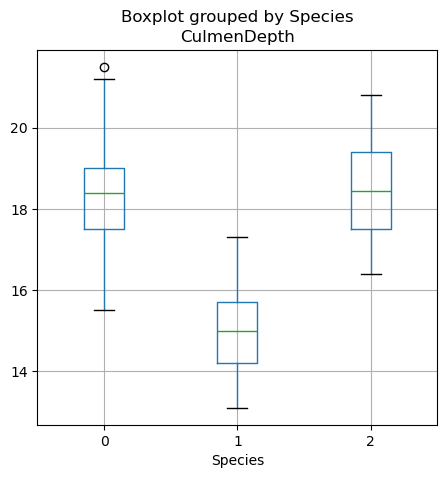

Unikalne wartości: 55


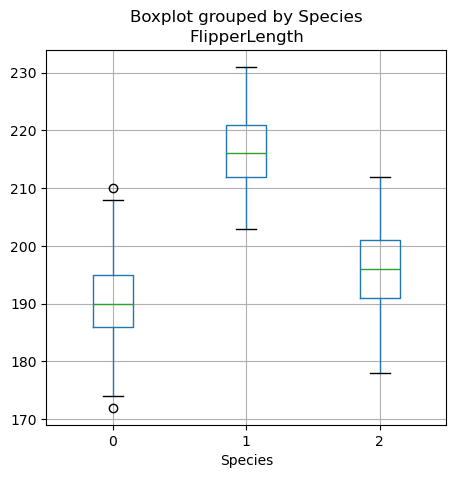

Unikalne wartości: 94


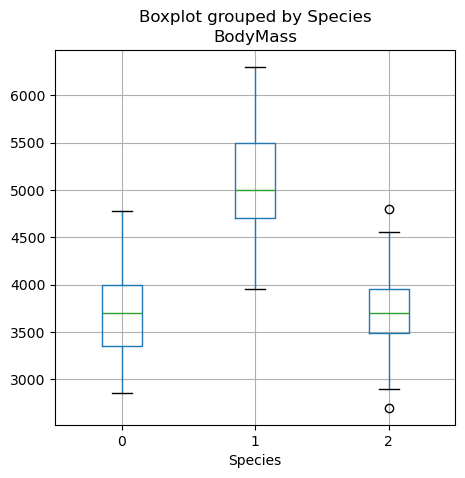

In [11]:
for col in features:
    print(f'Unikalne wartości: {len(df[col].unique())}')
    df.boxplot(column=col, by=target, figsize=(5, 5))
    plt.title(col)
    plt.show()

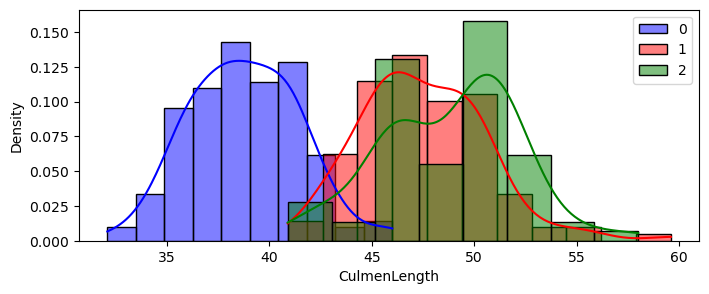

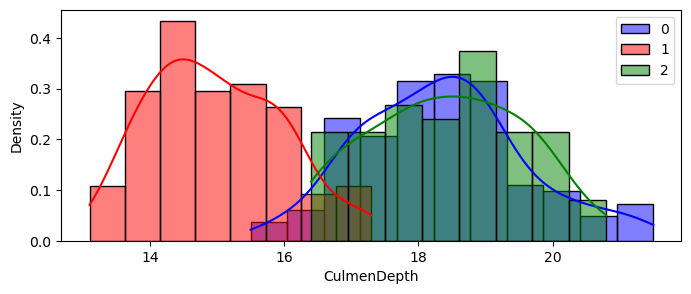

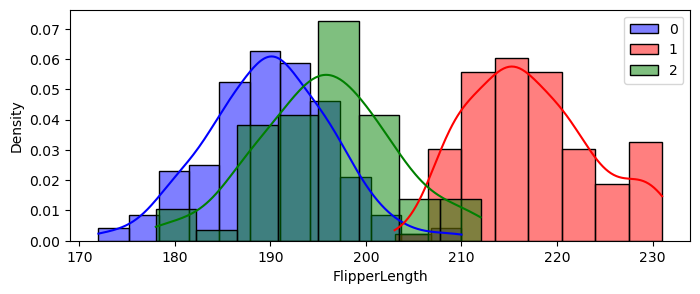

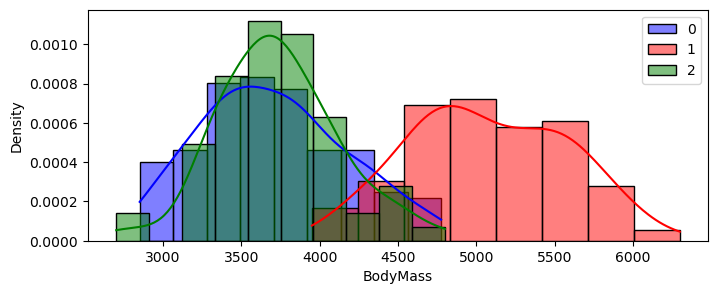

In [12]:
import seaborn as sns
for col in features:
    plt.figure(figsize=(8, 3))
    sns.histplot(df.loc[df['Species'] == 0, col], color='blue', kde=True, label='0', stat='density')
    sns.histplot(df.loc[df['Species'] == 1, col], color='red', kde=True, label='1', stat='density')
    sns.histplot(df.loc[df['Species'] == 2, col], color='green', kde=True, label='2', stat='density')
    plt.legend(loc='upper right')
    plt.show()

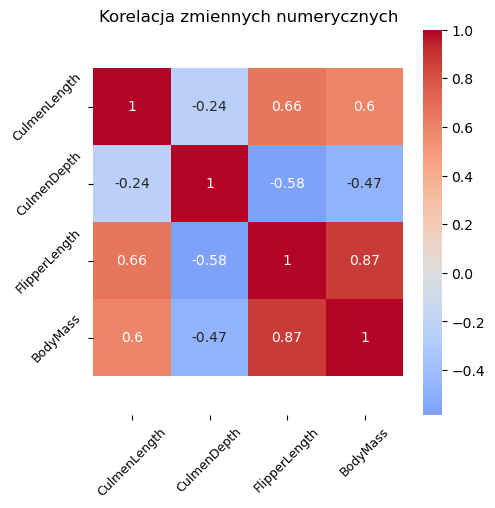

In [13]:
plt.figure(figsize=(5, 5))
ax = sns.heatmap(X.corr(),
                xticklabels=X.corr().columns,
                yticklabels=X.corr().columns,
                cmap='coolwarm',
                annot=True,
                center=0)

plt.title('Korelacja zmiennych numerycznych')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=9, rotation=45)
plt.show()

In [14]:
X.corr()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
CulmenLength,1.000000,-0.235053,0.656181,0.595110
CulmenDepth,-0.235053,1.000000,-0.583851,-0.471916
FlipperLength,0.656181,-0.583851,1.000000,0.871202
BodyMass,0.595110,-0.471916,0.871202,1.000000


Dane są silnie skorelowane. Może to nie dać dobrych wyników w modelach liniowych. Pomocna może również okazać się regularyzacja i PCA.

### 3. Podzielenie danych na train i test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 4. Stworzenie Pipeline'u i Param Grid

In [16]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', LogisticRegression())
])

In [17]:
param_grid = [
    # 1. Logistic Regression
    {
        'clf': [LogisticRegression(max_iter=5000, random_state=42)],
        'clf__solver': ['liblinear', 'saga'],  
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10],
        'pca__n_components': [None, 2, 3]
    },

    # 2. KNeighborsClassifier
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        'pca__n_components': [None, 2, 3]
    },

    # 3. DecisionTreeClassifier
    {
        'clf': [DecisionTreeClassifier(random_state=42)],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 3, 5],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2],
        'pca__n_components': [None, 2, 3]
    },

    # 4. SVC
    {
        'clf': [SVC(random_state=42)],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto'],
        'pca__n_components': [None, 2, 3]
    },

    # 5. RandomForestClassifier
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [None, 3, 5],
        'clf__min_samples_leaf': [1, 2],
        'pca__n_components': [None, 2, 3]
    },

    # 6. AdaBoostClassifier
    {
        'clf': [AdaBoostClassifier(random_state=42)],
        'clf__n_estimators': [50, 100],
        'clf__learning_rate': [0.1, 1.0],
        'pca__n_components': [None, 2, 3]
    },
]

### 5. Stworzenie GridSearchCV

In [18]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring={
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro'
    },
    refit='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(max_iter=5000,
                                                     random_state=42)],
                          'clf__C': [0.01, 0.1, 1, 10],
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear', 'saga'],
                          'pca__n_components': [None, 2, 3]},
                         {'clf': [KNeighborsClassifier()],...
                         {'clf': [RandomForestClassifier(random_state=42)],
                          'clf__max_depth': [None, 3, 5],
                          'clf__min_samples_leaf': [1, 2],
                          'clf__n_estimators': [50, 100],
                          'pca__n_components': [None, 2, 3]},
                         {'clf': [AdaBoostClassifier(random_state=42)],
                          'clf__learning_rate': [0.1, 1.0],
                          'clf__n_estimators': [50, 100],
                          'pca__n_components': [None, 2, 3]}],
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)

### 6. Wyświetlenie wyników:

In [19]:
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Najlepsze parametry: {'clf': SVC(random_state=42), 'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'pca__n_components': 3}
Najlepszy score: 1.0


In [20]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_f1_macro', inplace=True)

In [21]:
results[
    [
        'params',
        'mean_test_accuracy',
        'std_test_accuracy',
        'mean_test_f1_macro',
        'std_test_f1_macro'
    ]
].head(10)

,params,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
188,"{'clf': SVC(random_state=42), 'clf__C': 10, 'c...",1.000000,0.000000,1.000000,0.000000
182,"{'clf': SVC(random_state=42), 'clf__C': 10, 'c...",1.000000,0.000000,1.000000,0.000000
36,"{'clf': LogisticRegression(max_iter=5000, rand...",0.992725,0.014553,0.991371,0.017258
38,"{'clf': LogisticRegression(max_iter=5000, rand...",0.992725,0.014553,0.991371,0.017258
59,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.992725,0.014553,0.990698,0.018684
41,"{'clf': LogisticRegression(max_iter=5000, rand...",0.989021,0.016774,0.988535,0.017759
53,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.989153,0.016572,0.986685,0.020479
47,"{'clf': LogisticRegression(max_iter=5000, rand...",0.989021,0.016774,0.986586,0.020622
44,"{'clf': LogisticRegression(max_iter=5000, rand...",0.989021,0.016774,0.986334,0.020959
42,"{'clf': LogisticRegression(max_iter=5000, rand...",0.989021,0.016774,0.986334,0.020959


In [22]:
y_pred = best_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", acc_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.9855072463768116

Confusion Matrix:
[[30  0  0]
 [ 0 25  0]
 [ 1  0 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



Wnioski: Dwa najlepsze modele (SVC z parametrami C=10, kernel rbf) osiągnęły idealne wyniki (mean_test_accuracy=1.0 i std_test_accuracy=0.0), co sugeruje, że są wyjątkowo dobre dopasowanie do danych. Z kolei inne modele (LogisticRegression, kNN) wykazują minimalne różnice w skuteczności, co potwierdza stabilność. Sprawdźmy jednak różne seedy przy train_test_split dla pewnośći.

### 7. Dalsze testy z różnymi seedami:

In [23]:
seeds = [5, 23, 42, 123, 420, 999, 2025, 1, 2, 3]

test_results = []

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=seed,
        stratify=y  # jeśli chcesz zachować proporcje klas
    )

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)

    test_results.append({
        'seed': seed,
        'best_params': grid_search.best_params_,
        'cv_best_score': grid_search.best_score_,
        'test_accuracy': acc_test
    })

test_results_df = pd.DataFrame(test_results)

print(test_results_df)

mean_acc = test_results_df['test_accuracy'].mean()
std_acc = test_results_df['test_accuracy'].std()

print(f"\nŚrednie accuracy na test: {mean_acc:.4f} (odchylenie std: {std_acc:.4f})")

   seed                                        best_params  cv_best_score  \
0     5  {'clf': KNeighborsClassifier(), 'clf__n_neighb...       1.000000   
1    23  {'clf': LogisticRegression(max_iter=5000, rand...       0.996364   
2    42  {'clf': SVC(random_state=42), 'clf__C': 10, 'c...       0.996364   
3   123  {'clf': SVC(random_state=42), 'clf__C': 10, 'c...       0.992727   
4   420  {'clf': LogisticRegression(max_iter=5000, rand...       0.996296   
5   999  {'clf': LogisticRegression(max_iter=5000, rand...       1.000000   
6  2025  {'clf': LogisticRegression(max_iter=5000, rand...       0.992660   
7     1  {'clf': LogisticRegression(max_iter=5000, rand...       0.996364   
8     2  {'clf': LogisticRegression(max_iter=5000, rand...       0.996364   
9     3  {'clf': LogisticRegression(max_iter=5000, rand...       0.989024   

   test_accuracy  
0       0.971014  
1       0.985507  
2       1.000000  
3       1.000000  
4       0.985507  
5       0.971014  
6       1.000000  


In [24]:
print("\nNajlepsze parametry dla każdego seeda:")
print(test_results_df['best_params'].value_counts())


Najlepsze parametry dla każdego seeda:
best_params
{'clf': SVC(random_state=42), 'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'pca__n_components': 3}                                           2
{'clf': LogisticRegression(max_iter=5000, random_state=42), 'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'pca__n_components': None}         2
{'clf': KNeighborsClassifier(), 'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance', 'pca__n_components': 3}                                   1
{'clf': LogisticRegression(max_iter=5000, random_state=42), 'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'pca__n_components': None}    1
{'clf': LogisticRegression(max_iter=5000, random_state=42), 'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'pca__n_components': None}    1
{'clf': LogisticRegression(max_iter=5000, random_state=42), 'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'pca__n_components': 3}       1
{'clf': Logi

Wnioski: Te same modele przy różnych seedach, również spisują się świetnie. Dla 3 różnych najlepszych klasyfikatorów stworzę więc osobne pipeliny z ewaluacją i wizualizacją.

### 8. Najlepsze modele i podsumowanie w formie wizualizacji

#### 8.1 Funkcja do ewaluacji najlepszych modeli

In [53]:

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, pca_components_for_viz=2):

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    acc_test = accuracy_score(y_test, y_pred)
    print("Accuracy on test set:", acc_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Convert the multi-class classifier to multiple binary classifiers
    pipeline_ovr = OneVsRestClassifier(pipeline)
    pipeline_ovr.fit(X_train, y_train)
    
    # Plot ROC curve for each class
    fig, axes = plt.subplots(1, len(pipeline_ovr.classes_), figsize=(18, 5))
    for i, ax in enumerate(axes):
        RocCurveDisplay.from_estimator(pipeline_ovr.estimators_[i], X_test, y_test == pipeline_ovr.classes_[i], ax=ax)
        ax.set_title(f'ROC Curve for class {pipeline_ovr.classes_[i]}')
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix for pipeline
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    
    # Reduce the number of features to 2 using PCA for visualization
    pca_2d = PCA(n_components=pca_components_for_viz)
    X_train_2d = pca_2d.fit_transform(X_train)
    X_test_2d = pca_2d.transform(X_test)
    
    # Fit the pipeline to the 2D training data
    pipeline_2d = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', pipeline.named_steps['clf'])  # Use the classifier from the pipeline
    ])
    pipeline_2d.fit(X_train_2d, y_train)
    
    plot_decision_regions(X_train_2d, y_train.values, clf=pipeline_2d, legend=2, ax=ax[1])
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 2')
    ax[1].set_title('Classification Surface')
    
    plt.tight_layout()
    plt.show()

#### 8.2 Najlepsze modele:

In [54]:
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('clf', SVC(C=10, gamma='auto', kernel='rbf', random_state=42, probability=True))
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('clf', KNeighborsClassifier(n_neighbors=3, p=2, weights='distance'))
])

pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None)),
    ('clf', LogisticRegression(C=10, penalty='l1', solver='saga', max_iter=5000, random_state=42))
])


#### 8.3 Wyniki dla SVM:

Accuracy on test set: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



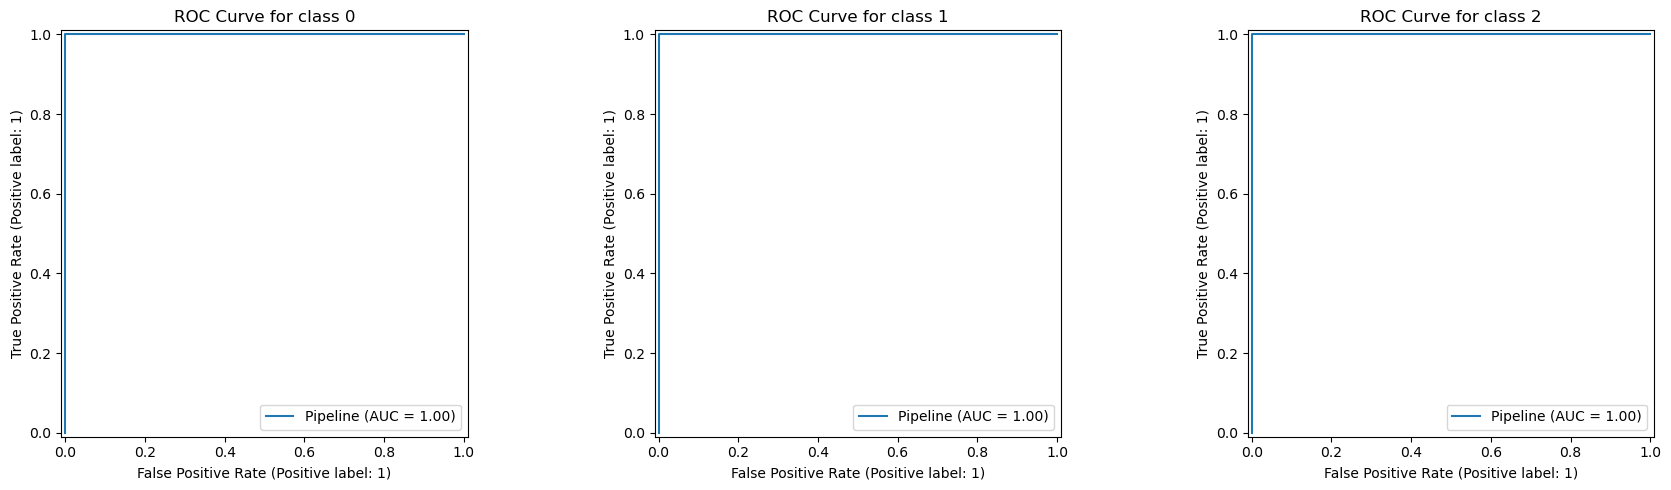

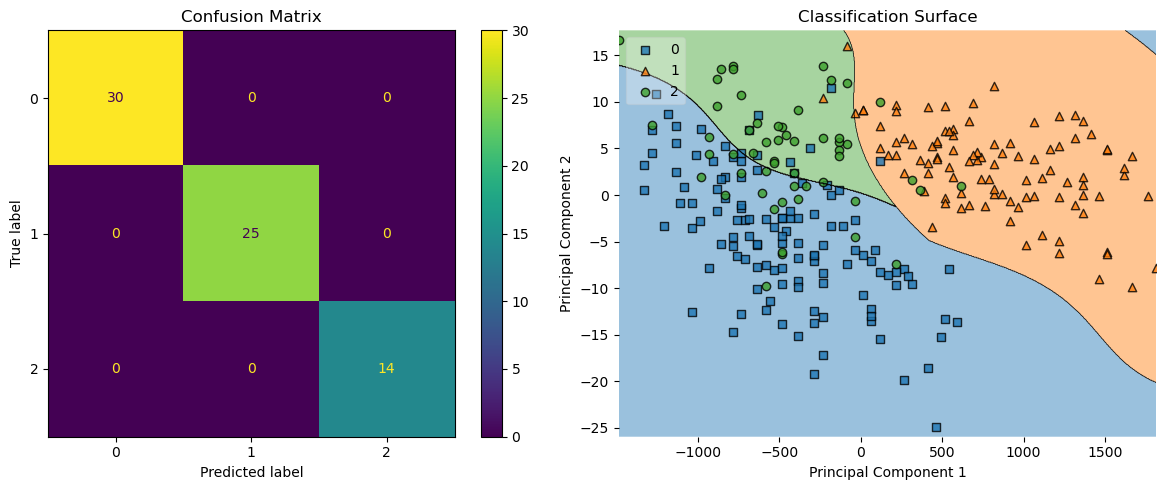

In [55]:
evaluate_pipeline(pipeline_svc, X_train, y_train, X_test, y_test, pca_components_for_viz=2)

#### 8.4 Wyniki dla KNN:

Accuracy on test set: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



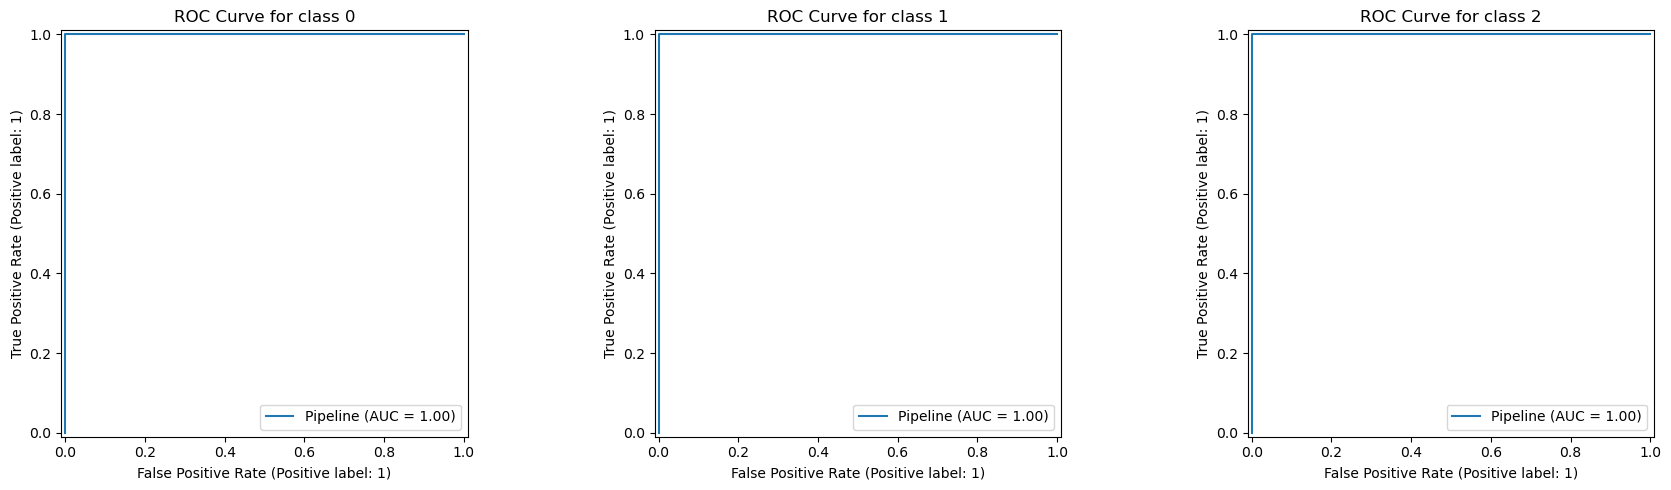

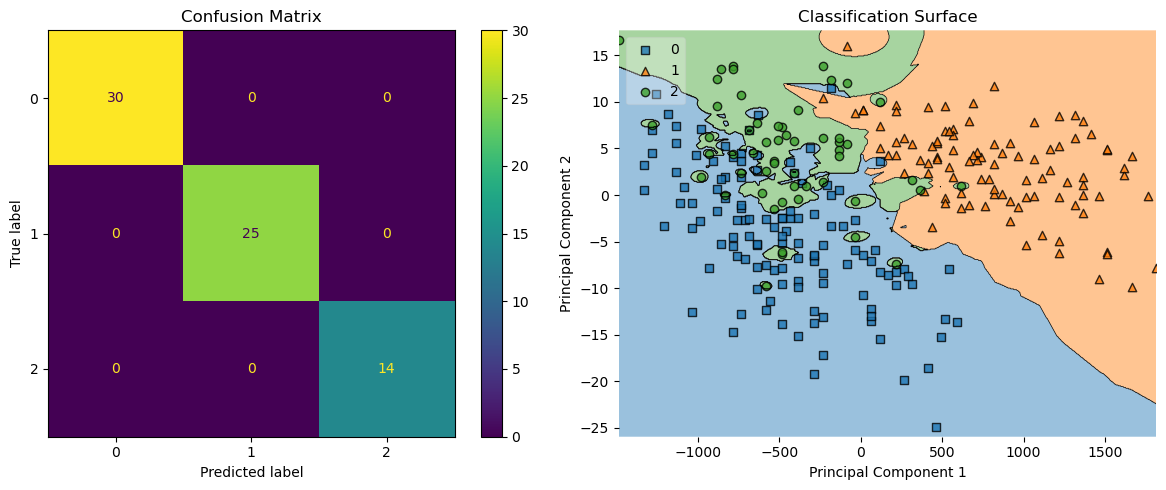

In [56]:
evaluate_pipeline(pipeline_knn, X_train, y_train, X_test, y_test, pca_components_for_viz=2)

#### 8.5 Wyniki dla Regresji Logistycznej:

Accuracy on test set: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



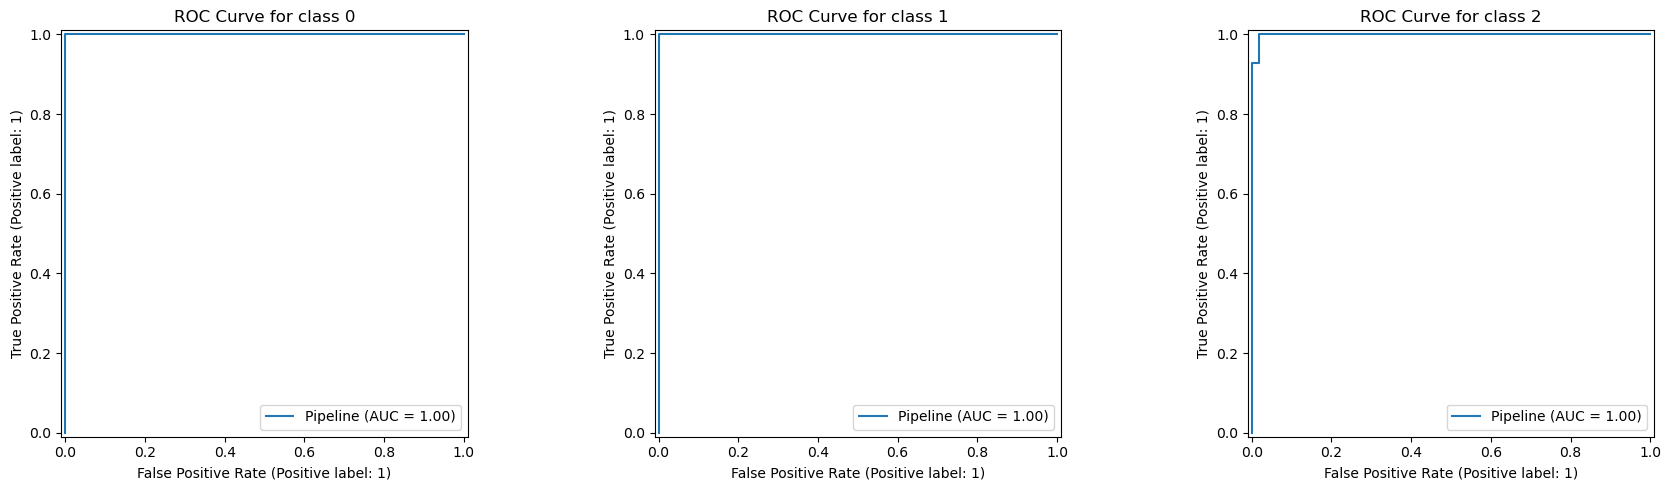

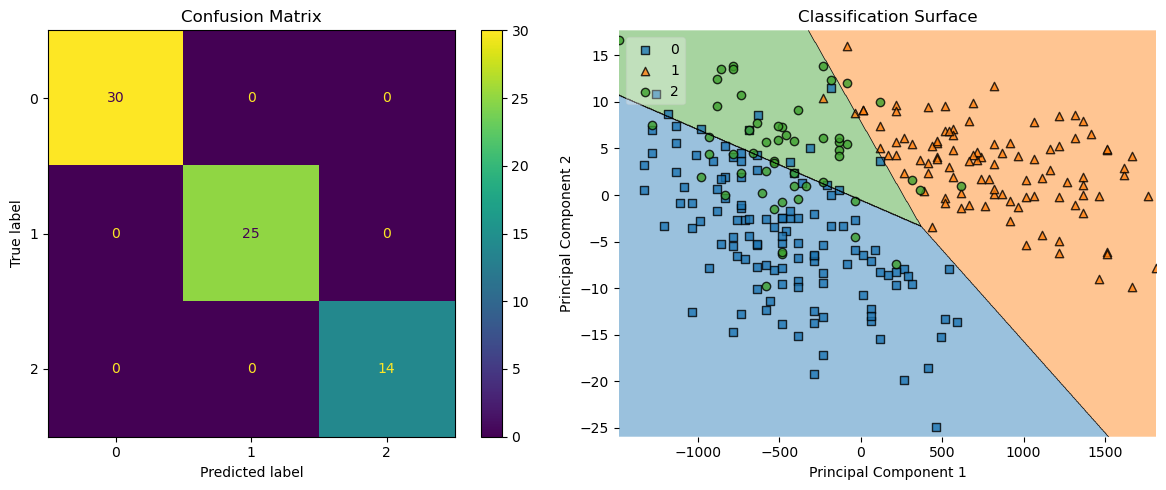

In [57]:
evaluate_pipeline(pipeline_logreg, X_train, y_train, X_test, y_test, pca_components_for_viz=2)

### 9. Wnioski końcowe

##### Modele spisaly się idealnie. Jest to dość mały dataset, z bardzo wyraźnie oddzielonymi cechami. Widać to na boxplotach i histogramach w początkowej wizualizacji danych. Mimo sporej korelacji przy odpowiednich parametrach modele poradziły sobie. Użyte modele znalezione przez Gridsearch pokrywają się z tymi, które wskazuje "sklearn cheatsheet" jako najlepsze dla tego problemu. Zamiast plot_clasification_surface(), użyłem plot_decision_surface(), które okazało się łatwiejsze w przypadku spłaszczania wielowymiarowości (cztery cechy spłaszczone do dwóch wymiarów). Właśnie z uwagi na to wizualizacje nie są perfekcyjne.